In [1]:
### Import Packages ###
import os
import ast
import numpy as np
import math as math
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Local Packages ###
from utils.Main import *
from utils.Selector import *
from utils.Auxiliary import *
from utils.Prediction import *

In [2]:
### Get Directory ###
cwd = os.getcwd()
ParentDirectory = os.path.abspath(os.path.join(cwd, ".."))

### DataType ###
DataFileInput = "BostonHousingBinned"

# One Iteration

## Inputs

In [3]:
TopCModels = 50
Seed = 1
TestProportion = 0.2
CandidateProportion = 0.8
SelectorType = TreeEnsembleQBCFunction
# ModelType = RandomForestClassificationFunction
ModelType = TreeFarmsFunction
DataArgs = {}
SelectorArgs = {"TopCModels": 10}
ModelArgs = {"TopCModels": TopCModels, 
             "config" : {"regularization": 0.01, 
             "rashomon_bound_multiplier": 0.05}, 
             "Seed": Seed,
             "n_estimators": TopCModels,
             "Type":"Classification"}


In [4]:
# ### Parameter Vector ###
# k=3
# ParameterVector = pd.read_csv(os.path.join(ParentDirectory, "Data", "ParameterVectors", "ParameterVector" + DataFileInput + ".csv"))
# Seed = int(ParameterVector.iloc[k]["Seed"])
# TestProportion = float(ParameterVector.iloc[k]["TestProportion"])
# CandidateProportion = float(ParameterVector.iloc[k]["CandidateProportion"])
# SelectorType = globals().get(ParameterVector.iloc[k]["SelectorType"], None)
# # ModelType = globals().get(ParameterVector.iloc[k]["ModelType"], None)
# ModelType = RandomForestClassificationFunction
# DataArgs = ast.literal_eval(ast.literal_eval(ParameterVector.iloc[k]["DataArgs"]))
# SelectorArgs = ast.literal_eval(ast.literal_eval(ParameterVector.iloc[k]["SelectorArgs"].replace("[","").replace("]","")))
# ModelArgs = ast.literal_eval(ast.literal_eval(ParameterVector.iloc[k]["ModelArgs"].replace("[","").replace("]","")))


# Set Up

In [5]:
### Run Time ###
StartTime = time.time()

### Set Up ###
random.seed(Seed)
np.random.seed(Seed)
ErrorVec = []
SelectedObservationHistory = []

In [6]:
### Generate Data ###
if(DataFileInput == "Simulate"):
    from utils.Main import DataGeneratingProcess                             ### NOTE: Why is this not imported from utils.Main import *
    df = DataGeneratingProcess(**DataArgs)
else:
    df = LoadData(DataFileInput)

In [7]:
### Train Test Candidate Split
from utils.Main import TrainTestCandidateSplit                           ### NOTE: Why is this not imported from utils.Main import *
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

In [8]:
df_Train = pd.concat([df_Train, df_Candidate], ignore_index=True)

In [9]:
### Selector Arguments ###
SelectorArgs["df_Train"] = df_Test                                     # NOTE: Change to df_Test if there is a test set
SelectorArgs["df_Candidate"] = df_Candidate
SelectorArgs["Model"] = ""
# SelectorArgsFiltered = FilterArguments(SelectorType, SelectorArgs)

In [10]:
### Model Arguments ###
ModelArgs['df_Train'] = df_Train
# ModelArgsFiltered = FilterArguments(ModelType, ModelArgs)

# Learning Procedure

In [11]:
### Set Up ###
ErrorVec = []
SelectedObservationHistory = []

In [12]:
i=0

In [13]:
### Prediction Model ###
print("Iteration: " + str(i))
ModelArgsFiltered = FilterArguments(ModelType, ModelArgs)
Model = ModelType(**ModelArgsFiltered)
if "Model" in SelectorArgs.keys(): SelectorArgs['Model'] = Model            # NOTE: THIS IS NOT DYNAMIC

Iteration: 0
null
treefarms reported successful execution
training completed. Number of trees in the Rashomon set: 9
Finding Optimal Objective...
{
  "false": {
    "complexity": 0.009999999776482582,
    "loss": 0.037128712981939316,
    "name": "Y",
    "prediction": "False"
  },
  "feature": 8,
  "model_objective": 0.12415841966867447,
  "name": "RM_3",
  "reference": 1.0,
  "relation": "==",
  "true": {
    "false": {
      "false": {
        "complexity": 0.009999999776482582,
        "loss": 0.012376237660646439,
        "name": "Y",
        "prediction": "False"
      },
      "feature": 9,
      "name": "PTRATIO_1",
      "reference": 1.0,
      "relation": "==",
      "true": {
        "complexity": 0.009999999776482582,
        "loss": 0.004950494971126318,
        "name": "Y",
        "prediction": "True"
      },
      "type": "rational"
    },
    "feature": 3,
    "name": "NOX_1",
    "reference": 1.0,
    "relation": "==",
    "true": {
      "complexity": 0.009999999776

In [14]:
# ### Current Error ###
TestErrorVal = TestErrorFunction(Model, df_Test, ModelArgs["Type"])        # NOTE: Change to df_Test if there is a test set
if(len(TestErrorVal) > 1):
    AllErrors = TestErrorVal                                                # Rashomon gives all errors of Rashomon
    CurrentError = float(np.min(AllErrors))                                 # Extract the best one
else: 
    CurrentError = TestErrorVal                                             # One output for non-Rashomon
    AllErrors = [None]
SelectorArgs["AllErrors"] = AllErrors                                       # Use AllErrors in RashomonQBC
ErrorVec.append(CurrentError)


---

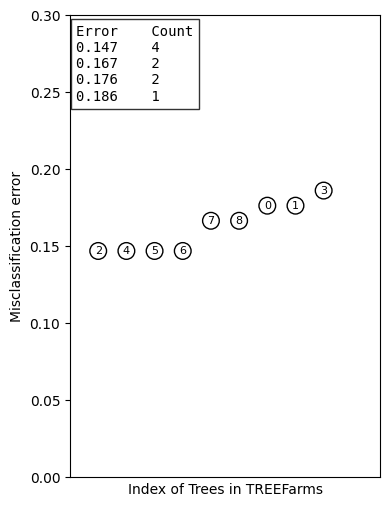

In [15]:
PlotTreeFarmsDecisionTreeErrors(AllErrors, order_errors=True)


---

# Jump Here

In [47]:
### Sampling Procedure ###
SelectorArgsFiltered = FilterArguments(SelectorType, SelectorArgs)
QueryObservationIndex = SelectorType(**SelectorArgsFiltered)
QueryObservation = df_Candidate.loc[[QueryObservationIndex]] # or should this be iloc

TypeError: TreeEnsembleQBCFunction() missing 1 required positional argument: 'UniqueErrorsInput'

In [ ]:
### Update Train and Candidate Sets ###
df_Train = pd.concat([df_Train, QueryObservation])
df_Candidate = df_Candidate.drop(QueryObservationIndex)
### Update SelectorArgs and ModelArgs ###                                     # NOTE: THIS IS NOT DYNAMIC
if "df_Train" in ModelArgs.keys(): ModelArgs['df_Train'] = df_Train
if "df_Train" in SelectorArgs.keys(): SelectorArgs['df_Train'] = df_Train
if "df_Candidate" in SelectorArgs.keys(): SelectorArgs['df_Candidate'] = df_Candidate  

# Save

In [ ]:
# ### Return Simulation Parameters ###
# SimulationParameters = {"DataFileInput" : str(DataFileInput),
#                         "Seed" : str(Seed),
#                         "TestProportion" : str(TestProportion),
#                         "CandidateProportion" : str(CandidateProportion),
#                         "SelectorType" : str(SelectorType),
#                         "ModelType" : str(ModelType),
#                         "DataArgs" : str(DataArgs),
#                         # "SelectorArgs" : str(SelectorArgs),
#                         "ModelArgs" : str(FilterArguments(ModelType, ModelArgs).pop('df_Train', None))
#                         }

In [ ]:
# ### Return Time ###
# ElapsedTime = time.time() - StartTime

# ### Return Dictionary ###
# SimulationResults = {"ErrorVec" : pd.DataFrame(ErrorVec, columns =["Error"]),
#                             "SelectionHistory" : pd.DataFrame(SelectedObservationHistory, columns = ["ObservationID"]),
#                             "SimulationParameters" : SimulationParameters,
#                             "ElapsedTime" : ElapsedTime}